In [1]:
from nuscenes import NuScenes
import numpy as np
import open3d as o3d
import struct
from pyquaternion import Quaternion
import random
import datetime

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# version 및 데이터파일 위치
nuscenes_version = 'v1.0-mini'
nuscenes_dataroot = 'data/'

In [3]:
nusc = NuScenes(version = nuscenes_version, dataroot = nuscenes_dataroot, verbose=True)

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.565 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [4]:
## 원본 코드 참조
def radar_pcd_to_data(file_path):
    meta = []
    with open(file_path, 'rb') as f:
        for line in f:
            line = line.strip().decode('utf-8')
            meta.append(line)
            if line.startswith('DATA'):
                break
        data_binary = f.read()
    """
    meta : 
    
    ['# .PCD v0.7 - Point Cloud Data file format',
     'VERSION 0.7',
     'FIELDS x y z dyn_prop id rcs vx vy vx_comp vy_comp is_quality_valid ambig_state x_rms y_rms invalid_state pdh0 vx_rms vy_rms',
     'SIZE 4 4 4 1 2 4 4 4 4 4 1 1 1 1 1 1 1 1',
     'TYPE F F F I I F F F F F I I I I I I I I',
     'COUNT 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1',
     'WIDTH 125',
     'HEIGHT 1',
     'VIEWPOINT 0 0 0 1 0 0 0',
     'POINTS 125',
     'DATA binary']
     """
    
    invalid_states = [0]  # type: List[int]
    dynprop_states = range(7)  # type: List[int] # Use [0, 2, 6] for moving objects only.
    ambig_states = [3]  # type: List[int]
    
    assert meta[0].startswith('#'), 'First line must be comment'
    assert meta[1].startswith('VERSION'), 'Second line must be VERSION'
    sizes = meta[3].split(' ')[1:]
    types = meta[4].split(' ')[1:]
    counts = meta[5].split(' ')[1:]
    width = int(meta[6].split(' ')[1])
    height = int(meta[7].split(' ')[1])
    data = meta[10].split(' ')[1]
    feature_count = len(types)
    assert width > 0
    assert len([c for c in counts if c != c]) == 0, 'Error: COUNT not supported!'
    assert height == 1, 'Error: height != 0 not supported!'
    assert data == 'binary'
    
    unpacking_lut = {'F': {2: 'e', 4: 'f', 8: 'd'}, 'I': {1: 'b', 2: 'h', 4: 'i', 8: 'q'}, 'U': {1: 'B', 2: 'H', 4: 'I', 8: 'Q'}}
    types_str = ''.join([unpacking_lut[t][int(s)] for t, s in zip(types, sizes)])
    
    offset = 0
    point_count = width
    points_data = []
    for i in range(point_count):
        point_data = []
        for p in range(feature_count):
            start_p = offset
            end_p = start_p + int(sizes[p])
            assert end_p < len(data_binary)
            point_p = struct.unpack(types_str[p], data_binary[start_p:end_p])[0]
            point_data.append(point_p)
            offset = end_p
        points_data.append(point_data)
        
    point_data = np.array(points_data[0])
    points_data = np.array(points_data).transpose()
    
    invalid_states = cls.invalid_states if invalid_states is None else invalid_states
    dynprop_states = cls.dynprop_states if dynprop_states is None else dynprop_states
    ambig_states = cls.ambig_states if ambig_states is None else ambig_states
    
    valid = [p in invalid_states for p in points_data[-4, :]]
    points_data = points_data[:, valid]
    
    valid = [p in dynprop_states for p in points_data[3, :]]
    points_data = points_data[:, valid]
    
    valid = [p in ambig_states for p in points_data[11, :]]
    points_data = points_data[:, valid]
    
    """
    0 : x --> 1
    1 : y --> 2
    2 : z 
    3 : dyn_prop --> 7
    4 : id 
    5 : rcs --> 5
    6 : vx 
    7 : vy 
    8 : vx_comp --> 3
    9 : vy_comp --> 4
    10: is_quality_valid 
    11: ambig_state 
    12: x_rms 
    13: y_rms 
    14: invalid_state --> 8
    15: pdh0 --> 6
    16: vx_rms 
    17: vy_rms
            + t --> 9
    """
    return points_data

In [5]:
## 레이더의 경우 속도는 [8:10, :], 위치는 [:2, :] 사용
def static_to_global(points_data, global_cal_sensor, local_cal_sensor):
    global_data = np.vstack((points_data, np.zeros(points_data.shape[1])))
    global_data = np.dot(Quaternion(local_cal_sensor['rotation']).rotation_matrix, global_data)
    global_data = np.dot(Quaternion(global_cal_sensor['rotation']).rotation_matrix.T, global_data)
    global_data[2, :] = np.zeros(points_data.shape[1])
    
    return global_data

In [6]:
def one_anns_data_to_box(sample, sensor, sample_annotation):
    
    lidar_token = sample['data']['LIDAR_TOP']
    lidar_sample_data = nusc.get('sample_data', lidar_token)
    lidar_cal_sample = lidar_sample_data['calibrated_sensor_token']
    lidar_cal = nusc.get('calibrated_sensor', lidar_cal_sample)
    
    ego_token = lidar_sample_data['ego_pose_token']
    ego_data = nusc.get('ego_pose', ego_token)
    
    center = sample_annotation['translation']
    size = sample_annotation['size']
    
    yaw = Quaternion(ego_data['rotation']).yaw_pitch_roll[0]
    center = center - np.array(ego_data['translation'])
    center = np.dot(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse.rotation_matrix, center)
    #center = np.dot(Quaternion(lidar_cal['rotation']).inverse.rotation_matrix, center)
    #center = np.dot(Quaternion(ego_data['rotation']).rotation_matrix.T, center)
    center = np.dot(Quaternion(axis = [0, 0, 1], degrees = -90).rotation_matrix.T, center)
    
    
    w = size[0]
    l = size[1]
    h = size[2]
    
    x_corners = l / 2 * np.array([1,  1,  1,  1, -1, -1, -1, -1])
    y_corners = w / 2 * np.array([1, -1, -1,  1,  1, -1, -1,  1])
    z_corners = h / 2 * np.array([1,  1, -1, -1,  1,  1, -1, -1])
    
    corners = np.vstack((x_corners, y_corners, z_corners))
    
    
    #corners = np.dot(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse.rotation_matrix, corners)
    
    corners = np.dot(Quaternion(ego_data['rotation']).inverse.rotation_matrix, corners)
    corners = np.dot(Quaternion(sample_annotation['rotation']).inverse.rotation_matrix, corners)
    #corners = np.dot(Quaternion(axis = [0, 0, 1], degrees = 60).rotation_matrix.T, corners)
    
    x = center[0]
    y = center[1]
    z = center[2]
    
    corners[0, :] = corners[0, :] + x
    corners[1, :] = corners[1, :] + y
    corners[2, :] = corners[2, :] + z
    
    return corners[:2, [2, 3, 7, 6]]

In [7]:
def sample_anns_to_global(sample, sensor):
    anns_token = sample['anns']
    boxes = []
    for i in range(len(anns_token)):
        box = one_anns_data_to_box(sample, sensor, nusc.get('sample_annotation', anns_token[i]))
        boxes = boxes + [box.tolist()]
        
    return boxes

In [8]:
def one_radar_data_labeling(pos_data, boxes):
    an = 0
    for i in range(len(boxes)):
        if an == 1:
            return an
        
        x_dis = max(boxes[i][0]) - min(boxes[i][0])
        y_dis = max(boxes[i][1]) - min(boxes[i][1])
        
        x_max = max(boxes[i][0]) + x_dis * 0.2
        x_min = min(boxes[i][0]) - x_dis * 0.2
        y_max = max(boxes[i][1]) + y_dis * 0.2
        y_min = min(boxes[i][1]) - y_dis * 0.2
        
        if pos_data[0] < x_max and pos_data[0] > x_min and pos_data[1] < y_max and pos_data[1] > y_min:
            an = 1
            return an
    return an

In [9]:
def radar_only_one_sensor_to_data(sample, sensor, t):
    """
    sensor : 
    
    RADAR_FRONT
    RADAR_FRONT_LEFT
    RADAR_FRONT_RIGHT
    RADAR_BACK_LEFT
    RADAR_BACK_RIGHT
    LIDAR_TOP
    CAM_FRONT
    CAM_FRONT_RIGHT
    CAM_BACK_RIGHT
    CAM_BACK
    CAM_BACK_LEFT
    CAM_FRONT_LEFT
    """
    sensor_token = sample['data'][sensor]
    sensor_data = nusc.get('sample_data', sensor_token)
    file_path = 'data/' + sensor_data['filename']
    sensor_cal_token = sensor_data['calibrated_sensor_token']
    seneor_cal = nusc.get('calibrated_sensor', sensor_cal_token)
    
    global_seneor_token = sample['data']['LIDAR_TOP']
    global_seneor = nusc.get('sample_data', global_seneor_token)
    global_cal_token = global_seneor['calibrated_sensor_token']
    global_cal = nusc.get('calibrated_sensor', global_cal_token)
    
    points_data = radar_pcd_to_data(file_path)
    pos_data = points_data[:2, :]
    pos_data = static_to_global(pos_data, global_cal, seneor_cal)
    vel_data = points_data[8:10, :]
    vel_data = static_to_global(vel_data, global_cal, seneor_cal)
    
    num_data = len(points_data[0])
    
    boxes = sample_anns_to_global(sample, sensor)
    
    radar_data_set = []
    num_i = 0
    for i in range(num_data):
        
        label = one_radar_data_labeling(pos_data[:2, i], boxes)
        
        if points_data[15, i] > 3:
            break
        if points_data[14, i] in [1, 2, 3, 5, 6, 7, 15, 16]:
            break
        
        radar_data_set.append([])
        radar_data_set[num_i].append(pos_data[0, i])  # x
        radar_data_set[num_i].append(pos_data[1, i])  # y
        radar_data_set[num_i].append(vel_data[0, i])  # vx
        radar_data_set[num_i].append(vel_data[1, i])  # vy
        radar_data_set[num_i].append(points_data[5, i])  # rcs
        radar_data_set[num_i].append(points_data[15, i])  # pdh0
        radar_data_set[num_i].append(points_data[3, i])  # dyn_prop
        radar_data_set[num_i].append(points_data[14, i])  # invalid_state
        radar_data_set[num_i].append(t)  # t
        radar_data_set[num_i].append(label)
        
        num_i = num_i + 1
        
    return radar_data_set, boxes

In [10]:
def radar_sensor_to_data(sample, t):
    
    boxes = []
    
    radar_RADAR_FRONT_data_set, box = radar_only_one_sensor_to_data(sample, 'RADAR_FRONT', t)
    boxes = boxes + box
    radar_RADAR_FRONT_LEFT_data_set, box = radar_only_one_sensor_to_data(sample, 'RADAR_FRONT_LEFT', t)
    boxes = boxes + box
    radar_RADAR_FRONT_RIGHT_data_set, box = radar_only_one_sensor_to_data(sample, 'RADAR_FRONT_RIGHT', t)
    boxes = boxes + box
    radar_RADAR_BACK_LEFT_data_set, box = radar_only_one_sensor_to_data(sample, 'RADAR_BACK_LEFT', t)
    boxes = boxes + box
    radar_RADAR_BACK_RIGHT_data_set, box = radar_only_one_sensor_to_data(sample, 'RADAR_BACK_RIGHT', t)
    boxes = boxes + box
    radar_data_set = radar_RADAR_FRONT_data_set + radar_RADAR_FRONT_LEFT_data_set + radar_RADAR_FRONT_RIGHT_data_set + radar_RADAR_BACK_LEFT_data_set + radar_RADAR_BACK_RIGHT_data_set
    
    return radar_data_set, boxes

In [11]:
def lidar_sensor_to_data(sample, t):
    """
    sensor : 
    
    LIDAR_TOP
    """
    sensor_token = sample['data']['LIDAR_TOP']
    sensor_data = nusc.get('sample_data', sensor_token)
    file_path = 'data/' + sensor_data['filename']
    
    lidar_bin = np.fromfile(file_path, dtype = np.float32)
    lidar_data_set = lidar_bin.reshape((-1, 5))
    
    lidar_data_set = lidar_data_set.tolist()
    
    for i in range(len(lidar_data_set)):
        lidar_data_set[i][4] = t
        
    return lidar_data_set

In [12]:
def sample_to_data_radar_lidar(sample):
    time = 0
    past_sample_token = sample['prev']
    while past_sample_token != '':
        time = time + 1
        
        past_sample = nusc.get('sample', past_sample_token)
        past_sample_token = past_sample['prev']
    
    if time < 4:
        return [], [], []
    
    radar_dataset = []
    lidar_dataset = []
    
    past_sample_token = sample['prev']
    now_sample = sample
    

    lidar_dataset = lidar_dataset + lidar_sensor_to_data(sample, time * 0.25)
    
    radardata, boxes = radar_sensor_to_data(sample, time * 0.25)
    radar_dataset = radar_dataset + radardata

    now_sample = nusc.get('sample', past_sample_token)
    past_sample_token = now_sample['prev']
    time = time - 1
    
    return radar_dataset, lidar_dataset, boxes

In [13]:
def nearnest_lidar_points(radar_point, lidar_dataset):
    distance_data = []
    
    for i in range(len(lidar_dataset)):
        dis = (radar_point[0] - lidar_dataset[i][0]) ** 2 + (radar_point[1] - lidar_dataset[i][1]) ** 2 + (0 - lidar_dataset[i][2]) ** 2
        distance_data.append([i, dis])
    
    for i in range(15):
        for j in range(len(lidar_dataset) - 1):
            if distance_data[i][1] > distance_data[j][1]:
                temp = distance_data[j][1]
                distance_data[j][1] = distance_data[i][1]
                distance_data[i][1] = temp
    
    nearnest_lider_dataset = []
    for i in range(15):
        nearnest_lider_dataset = nearnest_lider_dataset + [lidar_dataset[distance_data[i][0]]]
        
    return nearnest_lider_dataset

In [14]:
def radar_data_n_to_1000(radar_dataset, mid_lidar_data):
    
    ok_data_num = 0
    not_data_num = 0
    
    ok_data_list = []
    not_data_list = []
    
    while len(radar_dataset) < 1000:
        for i in range(len(radar_dataset)):
            if radar_dataset[i][-1] == 0:
                not_data_num = not_data_num + 1
                not_data_list.append(i)
            else:
                ok_data_num = ok_data_num + 1
                ok_data_list.append(i)
                
        choice_num = random.randrange(len(radar_dataset))
        if not_data_num < ok_data_num * 1.2:
            choice_num = random.choice(not_data_list)
        else:
            choice_num = random.choice(ok_data_list)

        radar_dataset = radar_dataset + [radar_dataset[choice_num]]
        mid_lidar_data = mid_lidar_data + [mid_lidar_data[choice_num]]
        
        
        
    return radar_dataset, mid_lidar_data

In [15]:
def final_lidar_dataset(radar_dataset, lidar_dataset):
    mid_lidar_data = []
    for i in range(len(radar_dataset)):
        mid_lidar_data = mid_lidar_data + [nearnest_lidar_points(radar_dataset[i], lidar_dataset)]
    
    radar_dataset, mid_lidar_data = radar_data_n_to_1000(radar_dataset, mid_lidar_data)
    
    final_lidar_data = []
    for i in range(len(mid_lidar_data)):
        final_lidar_data = final_lidar_data + mid_lidar_data[i]
    
    for i in range(1000):
        choice_num = random.randrange(len(lidar_dataset))
        final_lidar_data = final_lidar_data + [lidar_dataset[choice_num]]
    
    return radar_dataset, [final_lidar_data]

In [16]:
def radar_data_and_labal(radar_dataset):
    final_radar_data = []
    final_label_data = []
    for i in range(len(radar_dataset)):
        final_radar_data = final_radar_data + [radar_dataset[i][:-1]]
        final_label_data = final_label_data + radar_dataset[i][-1:]
        
    return [final_radar_data], final_label_data

In [17]:
my_scene = nusc.scene[2]
next_token = my_scene['first_sample_token']
sample_nbr = my_scene['nbr_samples']

In [18]:
button = 1

In [19]:
while next_token != '':
    now_sample = nusc.get('sample', next_token)
    next_token = now_sample['next']
    
    now_radar_data, now_lidar_data, now_boxes = sample_to_data_radar_lidar(now_sample)
    if now_radar_data== []:
        continue
    
    if button == 1:
        button = button + 1
        continue
    
    mid_radar_data, final_lidar_data = final_lidar_dataset(now_radar_data, now_lidar_data)
    final_radar_data, final_label = radar_data_and_labal(mid_radar_data)
    
    if button == 2:
        break

In [20]:
xyz_boxes = []
for i in range(len(now_boxes)):
    xyz_boxes.append([now_boxes[i][0][0], now_boxes[i][1][0], 0])
    xyz_boxes.append([now_boxes[i][0][1], now_boxes[i][1][1], 0])
    xyz_boxes.append([now_boxes[i][0][2], now_boxes[i][1][2], 0])
    xyz_boxes.append([now_boxes[i][0][3], now_boxes[i][1][3], 0])
xyz_boxes_np = np.array(xyz_boxes)
xyz_boxes_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(xyz_boxes_np))

In [21]:
xyz_radar = []
for i in range(len(now_radar_data)):
    xyz_radar.append([now_radar_data[i][0], now_radar_data[i][1], 0])
xyz_radar_np = np.array(xyz_radar)
xyz_radar_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(xyz_radar_np))

In [22]:
xyz_lidar = []
for i in range(len(now_lidar_data)):
    xyz_lidar.append([now_lidar_data[i][0], now_lidar_data[i][1], now_lidar_data[i][2]])
xyz_lidar_np = np.array(xyz_lidar)
xyz_lidar_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(xyz_lidar_np))

In [23]:
xyz_boxes_pcd.paint_uniform_color([0,0,1])
xyz_radar_pcd.paint_uniform_color([1,0.5,0])
xyz_lidar_pcd.paint_uniform_color([0,1,0])

PointCloud with 34688 points.

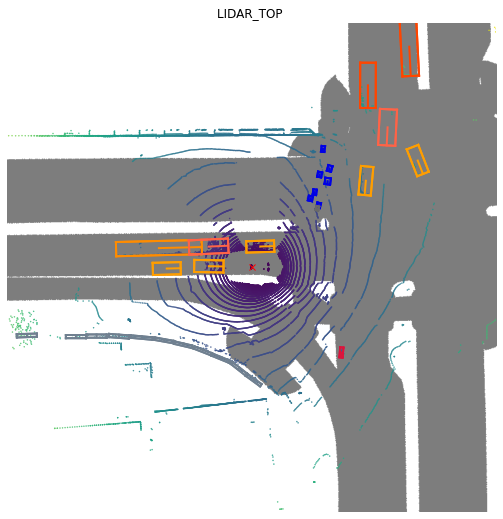

In [24]:
lidar_token = now_sample['data']['LIDAR_TOP']
nusc.render_sample_data(lidar_token)

In [25]:
o3d.visualization.draw_geometries([xyz_radar_pcd, xyz_boxes_pcd, xyz_lidar_pcd])